# Advanced Neural Nets
### Sofiia Stokop, FB-21mp

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown

### 1. Генерація зображень

In [19]:
# dataset https://www.kaggle.com/datasets/kostastokis/simpsons-faces Simpsons Faces
dataset = keras.preprocessing.image_dataset_from_directory(
    "C:/Users/100ko/Jupyter Notebooks/DA_Labs/simpsons/", label_mode=None, image_size=(64, 64), batch_size=128)
dataset = dataset.map(lambda x: x / 255.0)

Found 9877 files belonging to 1 classes.


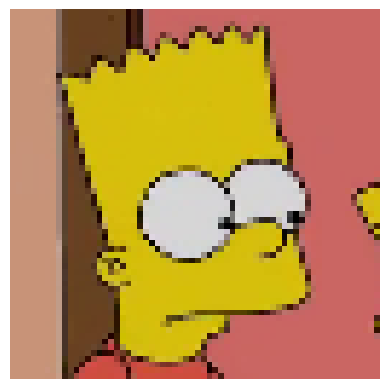

In [20]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [21]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 1)               

In [22]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(30, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 64)       131136    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0 

In [23]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator        
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [24]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [25]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.fit(dataset, epochs=150)

Epoch 1/150
78/78 [==============================] - 344s 4s/step - d_loss: 0.2987 - g_loss: 2.1232
Epoch 2/150
78/78 [==============================] - 329s 4s/step - d_loss: 0.2818 - g_loss: 2.7643
Epoch 3/150
78/78 [==============================] - 330s 4s/step - d_loss: 0.5582 - g_loss: 1.8426
Epoch 4/150
78/78 [==============================] - 331s 4s/step - d_loss: 0.4850 - g_loss: 2.0845
Epoch 5/150
78/78 [==============================] - 319s 4s/step - d_loss: 0.3082 - g_loss: 2.0269
Epoch 6/150
78/78 [==============================] - 328s 4s/step - d_loss: 0.6916 - g_loss: 1.5679
Epoch 7/150
78/78 [==============================] - 315s 4s/step - d_loss: 0.3447 - g_loss: 1.6747
Epoch 8/150
78/78 [==============================] - 300s 4s/step - d_loss: 0.4356 - g_loss: 1.4943
Epoch 9/150
78/78 [==============================] - 316s 4s/step - d_loss: 0.4252 - g_loss: 2.9353
Epoch 10/150
78/78 [==============================] - 314s 4s/step - d_loss: 0.2379 - g_loss: 4.5082

In [26]:
test = generator.predict( tf.random.normal(shape=(20, latent_dim)))

1/1 [==============================] - 0s 495ms/step


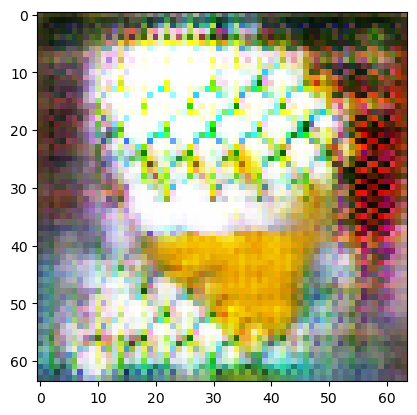

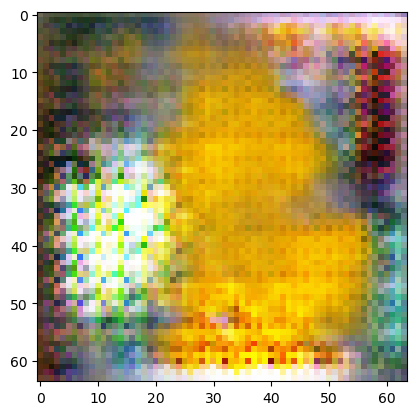

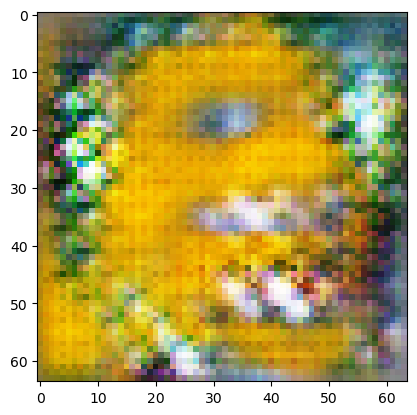

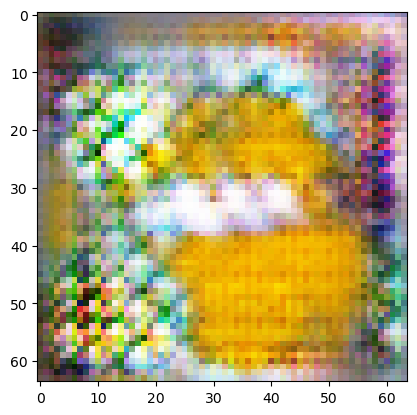

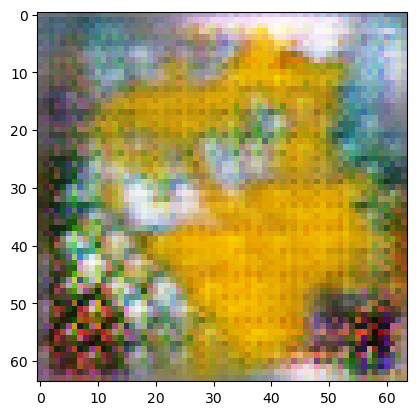

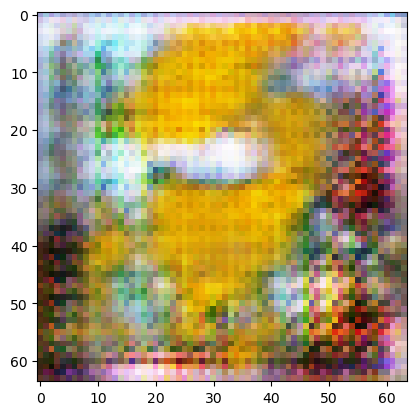

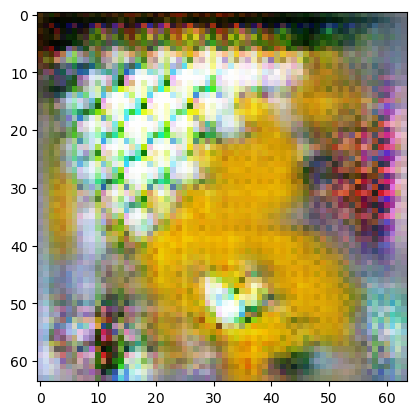

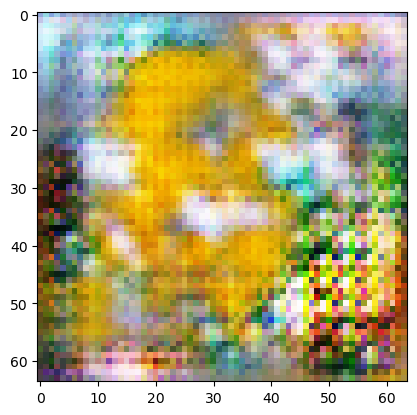

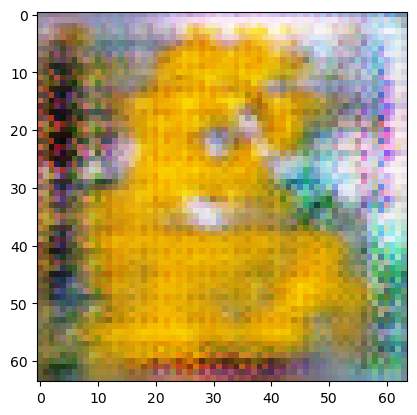

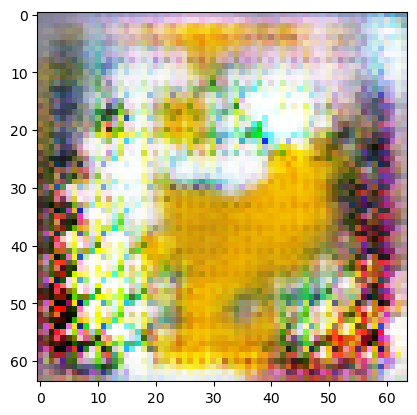

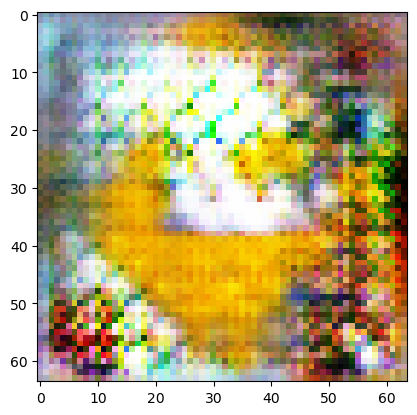

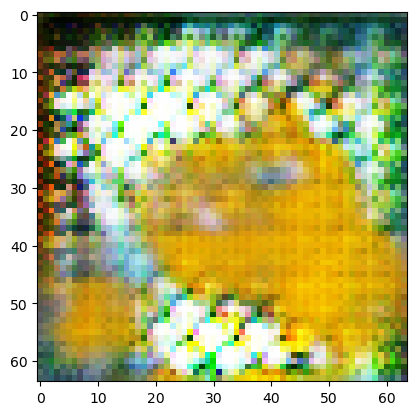

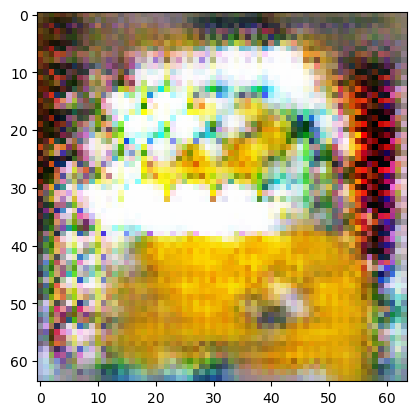

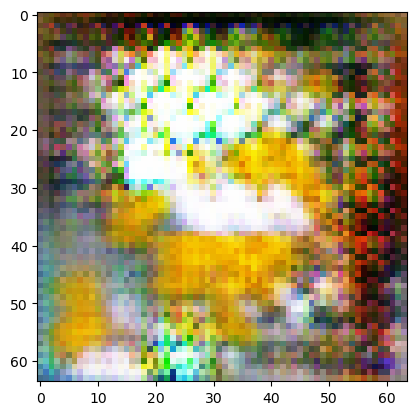

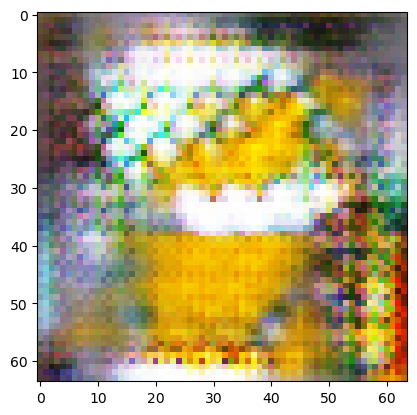

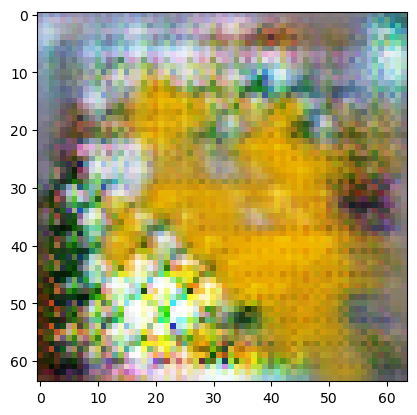

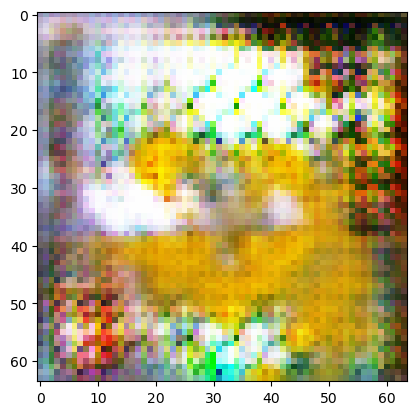

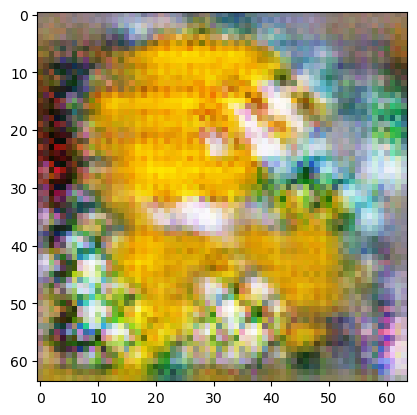

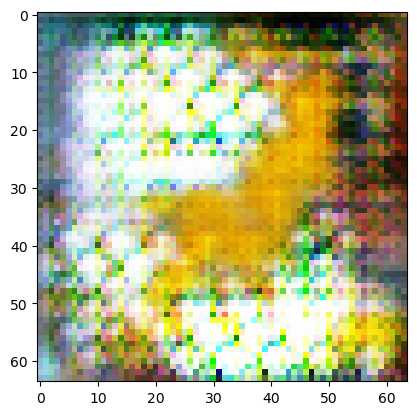

In [27]:
for i in range (0,19):
    plt.imshow(test[i])
    plt.show()

### Вирішити завдання машинного перекладу 

In [4]:
import pandas as pd

In [30]:
# dataset https://www.manythings.org/anki/ Japanese - English
data_path = "C://Users/100ko/Jupyter Notebooks/DA_Labs/eng-jpn.txt"
lines= pd.read_table(data_path,  names =['source', 'target', 'comments'])
lines.sample(5)

,source,target,comments
53849,This isn't a sheep. It's a goat.,これは羊じゃなくて、ヤギです！,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
11285,I remember it well.,よく覚えてるよ。,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
31925,Guess what happened to me.,私に何が起こったか聞いてよ。,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
40418,She was busy doing her hair.,彼女は髪をせっせと直していた。,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
7581,Please be seated.,お座り下さい。,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [40]:
batch_size = 64 
epochs = 100  
latent_dim = 256 
num_samples = 10000
data_path = "C://Users/100ko/Jupyter Notebooks/DA_Labs/eng-jpn.txt"

In [43]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")

decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[' ']] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

Number of samples: 10000
Number of unique input tokens: 73
Number of unique output tokens: 1455
Max sequence length for inputs: 18
Max sequence length for outputs: 28


In [45]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [46]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 78s 548ms/step - loss: 1.8510 - accuracy: 0.0459 - val_loss: 1.9775 - val_accuracy: 0.0523
Epoch 2/100
125/125 [==============================] - 71s 572ms/step - loss: 1.6786 - accuracy: 0.0529 - val_loss: 1.9309 - val_accuracy: 0.0552
Epoch 3/100
125/125 [==============================] - 64s 509ms/step - loss: 1.6665 - accuracy: 0.0532 - val_loss: 1.9493 - val_accuracy: 0.0539
Epoch 4/100
125/125 [==============================] - 67s 535ms/step - loss: 1.6595 - accuracy: 0.0537 - val_loss: 1.9096 - val_accuracy: 0.0556
Epoch 5/100
125/125 [==============================] - 69s 556ms/step - loss: 1.6540 - accuracy: 0.0556 - val_loss: 1.8901 - val_accuracy: 0.0590
Epoch 6/100
125/125 [==============================] - 73s 582ms/step - loss: 1.6464 - accuracy: 0.0573 - val_loss: 1.8954 - val_accuracy: 0.0594
Epoch 7/100
125/125 [==============================] - 86s 687ms/step - loss: 1.6342 - accuracy: 0.0596 - val_loss: 1.9541 -

Epoch 57/100
125/125 [==============================] - 65s 516ms/step - loss: 1.1452 - accuracy: 0.1347 - val_loss: 1.4947 - val_accuracy: 0.1246
Epoch 58/100
125/125 [==============================] - 65s 520ms/step - loss: 1.1363 - accuracy: 0.1361 - val_loss: 1.5074 - val_accuracy: 0.1246
Epoch 59/100
125/125 [==============================] - 64s 515ms/step - loss: 1.1275 - accuracy: 0.1372 - val_loss: 1.4966 - val_accuracy: 0.1247
Epoch 60/100
125/125 [==============================] - 64s 510ms/step - loss: 1.1190 - accuracy: 0.1386 - val_loss: 1.4942 - val_accuracy: 0.1245
Epoch 61/100
125/125 [==============================] - 63s 504ms/step - loss: 1.1109 - accuracy: 0.1399 - val_loss: 1.4804 - val_accuracy: 0.1284
Epoch 62/100
125/125 [==============================] - 63s 505ms/step - loss: 1.1025 - accuracy: 0.1410 - val_loss: 1.4778 - val_accuracy: 0.1297
Epoch 63/100
125/125 [==============================] - 63s 504ms/step - loss: 1.0925 - accuracy: 0.1429 - val_loss: 1

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


In [47]:
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [49]:
for seq_index in range(0,1000,25):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 28ms/step
Input sentence: Go.
Decoded sentence: 行け。

1/1 [==============================] - 0s 25ms/step
Input sentence: Jump.
Decoded sentence: 飛び

1/1 [==============================] - 0s 26ms/step
Input sentence: I try.
Decoded sentence: やってみた。

1/1 [==============================] - 0s 28ms/step
Input sentence: Get up.
Decoded sentence: 起きな。

1/1 [==============================] - 0s 34ms/step
Input sentence: Listen.
Decoded sentence: さあない。

1/1 [==============================] - 0s 25ms/step
Input sentence: Ask Tom.
Decoded sentence: トムに聞い。

1/1 [==============================] - 0s 26ms/step
Input sentence: Get Tom.
Decoded sentence: トムを見れて。

1/1 [==============================] - 0s 26ms/step
Input sentence: Goodbye.
Decoded sentence: さう？

1/1 [==============================] - 0s 26ms/step
Input sentence: Hug Tom.
Decoded sentence: トムを抱きして。

1/1 [==============================] - 0s 132ms/step
Input sentence: It's me.
Decoded sentence:

1/1 [==============================] - 0s 26ms/step
Input sentence: Here it is.
Decoded sentence: いい、どう。

1/1 [==============================] - 0s 28ms/step
Input sentence: I can sing.
Decoded sentence: 歌が好きい。

1/1 [==============================] - 0s 29ms/step
Input sentence: I feel sad.
Decoded sentence: 気分がいい。



### Проведіть експерименти з моделями бібліотеки HF Transformers

In [2]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
message = 'Football is the most exciting and popular game in the world'
classifier(message)

[{'label': 'POSITIVE', 'score': 0.9998573064804077}]

In [5]:
nlp_qa = pipeline('question-answering')
nlp_qa(context='Igor Sikorsky Kyiv Polytechnic Institute is a university based in Ukraine.', question='Where is based Igor Sikorsky Kyiv Polytechnic Institute ?')

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9845150709152222, 'start': 66, 'end': 73, 'answer': 'Ukraine'}

In [6]:
image = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
question = "Where is the cat?"

In [7]:
vqa = pipeline(task="vqa")
preds = vqa(image=image, question=question)
preds = [{"score": round(pred["score"], 4), "answer": pred["answer"]} for pred in preds]
preds

No model was supplied, defaulted to dandelin/vilt-b32-finetuned-vqa and revision 4355f59 (https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/136k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/470M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

[{'score': 0.9112, 'answer': 'snow'},
 {'score': 0.8796, 'answer': 'in snow'},
 {'score': 0.6717, 'answer': 'outside'},
 {'score': 0.0291, 'answer': 'on ground'},
 {'score': 0.027, 'answer': 'ground'}]